<a href="https://colab.research.google.com/github/micheleintrevado/ML4MDE/blob/main/PapersClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os
import nltk
import pickle
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, GlobalAveragePooling1D, SpatialDropout1D, Conv1D
from keras.models import Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.layers import TextVectorization
from keras.metrics import Precision, Recall, CategoricalAccuracy
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Loading

Load data from drive:

In [ ]:
# from google.colab import drive

# # Mount the drive
# drive.mount('/content/drive/', force_remount=False)

# # Define the data path
# DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Papers'

# train_file_path = join(DATA_PATH, 'train.csv')

Load data from external source:

In [3]:
train_file_path = r"https://raw.githubusercontent.com/micheleintrevado/ML4MDE/main/archive/train.csv"

In [4]:
train_set = pd.read_csv(train_file_path)
train_set.drop(columns=['ID'], inplace=True)
train_set.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


# Joining the title and abstract into a single text column

In [5]:
train_set["text"] = train_set["TITLE"] + " " + train_set["ABSTRACT"]
# train_set["text"] = train_set["ABSTRACT"]
train_set.drop(columns=["TITLE", "ABSTRACT"], inplace=True)

# Dataset Analysis

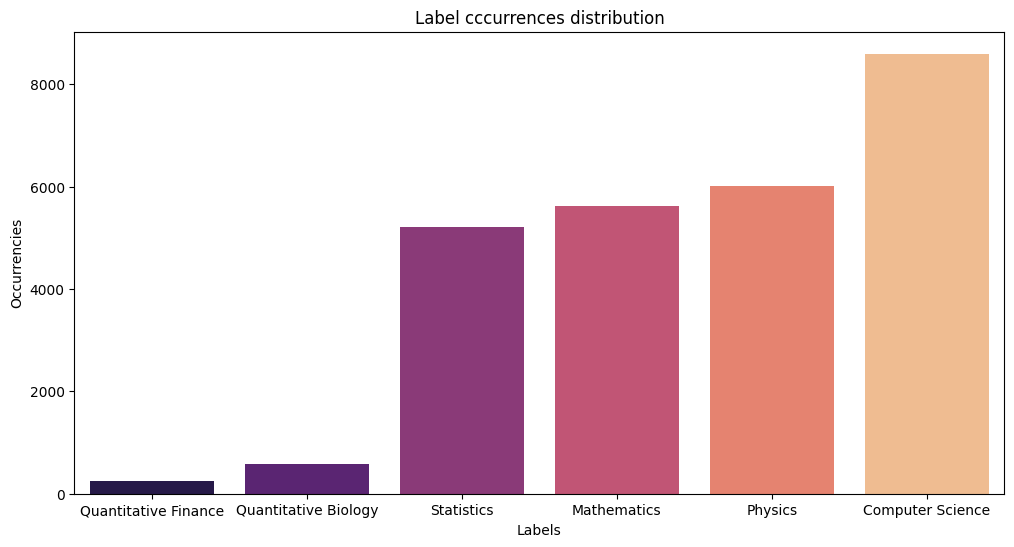

In [32]:
labels = train_set.columns.tolist()[0:-1]
counts = train_set[labels].sum().sort_values()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=counts.index, y=counts.values, palette='magma')

plt.xlabel('Labels')
plt.ylabel('Occurrencies')
plt.title('Label cccurrences distribution')

plt.show()

Plot of the most common words in the dataset's abstracts:

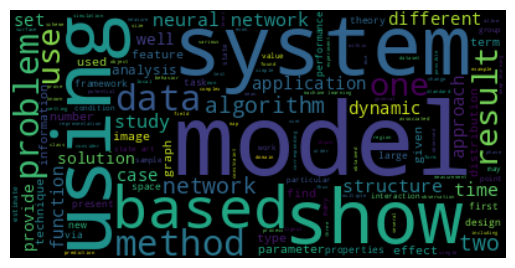

In [20]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(' '.join(train_set["text"]))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Dataset Preprocessing

In [8]:
contractions_dict = {
    "don't": "do not",
    "doesn't": "does not",
    "can't": "cannot",
    "isn't": "is not",
    "won't": "will not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "couldn't": "could not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "it's": "it is",
    "I'm": "I am",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "we're": "we are",
    "they're": "they are",
    "I've": "I have",
    "you've": "you have",
    "we've": "we have",
    "they've": "they have",
    "I'll": "I will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "we'll": "we will",
    "they'll": "they will",
    "I'd": "I would",
    "you'd": "you would",
    "he'd": "he would",
    "she'd": "she would",
    "we'd": "we would",
    "they'd": "they would",
    "I won't": "I will not",
    "you won't": "you will not",
    "he won't": "he will not",
    "she won't": "she will not",
    "we won't": "we will not",
    "they won't": "they will not",
}

In [9]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [10]:
def prepare_text(text: str):
    text = text.lower()
    text = text.replace('"', '')
    text = re.sub("[^a-zA-Z]", " ", text)
    text = " ".join([contractions_dict.get(word, word) for word in text.split()])
    words = [word for word in text.split() if word not in stop_words and len(word) > 1]
    return " ".join(words).strip()

In [11]:
train_set['text'] = train_set['text'].apply(prepare_text)
train_set

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
0,1,0,0,0,0,0,reconstructing subject specific effect maps pr...
1,1,0,0,0,0,0,rotation invariance neural network rotation in...
2,0,0,1,0,0,0,spherical polyharmonics poisson kernels polyha...
3,0,0,1,0,0,0,finite element approximation stochastic maxwel...
4,1,0,0,1,0,0,comparative study discrete wavelet transforms ...
...,...,...,...,...,...,...,...
20967,1,1,0,0,0,0,contemporary machine learning guide practition...
20968,0,1,0,0,0,0,uniform diamond coatings wc co hard alloy cutt...
20969,1,0,0,0,0,0,analysing soccer games clustering conceptors p...
20970,0,0,1,1,0,0,efficient simulation left tail sum correlated ...


In [12]:
X_data = train_set[['text']].values
y_data = train_set.iloc[:, 0:-1].values
print(f"len X_data: {len(X_data)}, len y_data: {len(y_data)}")

len X_data: 20972, len y_data: 20972


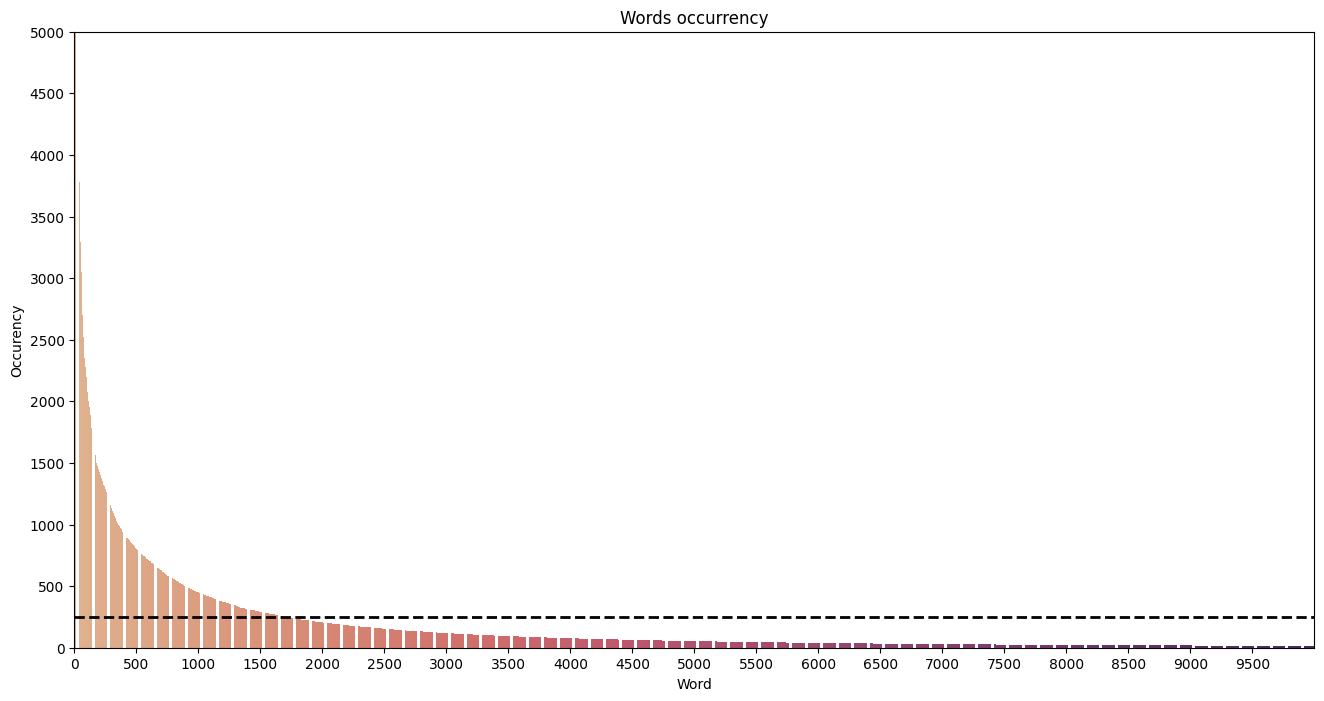

In [33]:
# Obtaining words list from X_data
words_list = list(map(lambda text: text.split(), map(lambda sublist: " ".join(sublist), X_data)))

# words list concatenate
words = [word for sublist in words_list for word in sublist]

words_count = Counter(words)

N = 10000
interval = 500

# Most common words
common_words = words_count.most_common(N)

words, frequencies = zip(*common_words)

plt.figure(figsize=(16, 8))
sns.barplot(x=range(len(words)), y=frequencies, palette="flare")
plt.title(f"Words occurrency")
plt.xlabel("Word")
plt.ylabel("Occurency")

x_labels = [f"{i * interval}" for i in range(N // interval)]

plt.xticks(range(0, N, interval), x_labels)

plt.ylim(0, 5000)
plt.yticks(range(0, 5000 + 1, interval))

plt.axhline(y=250, color="black", linestyle='--', linewidth=2)

plt.show()

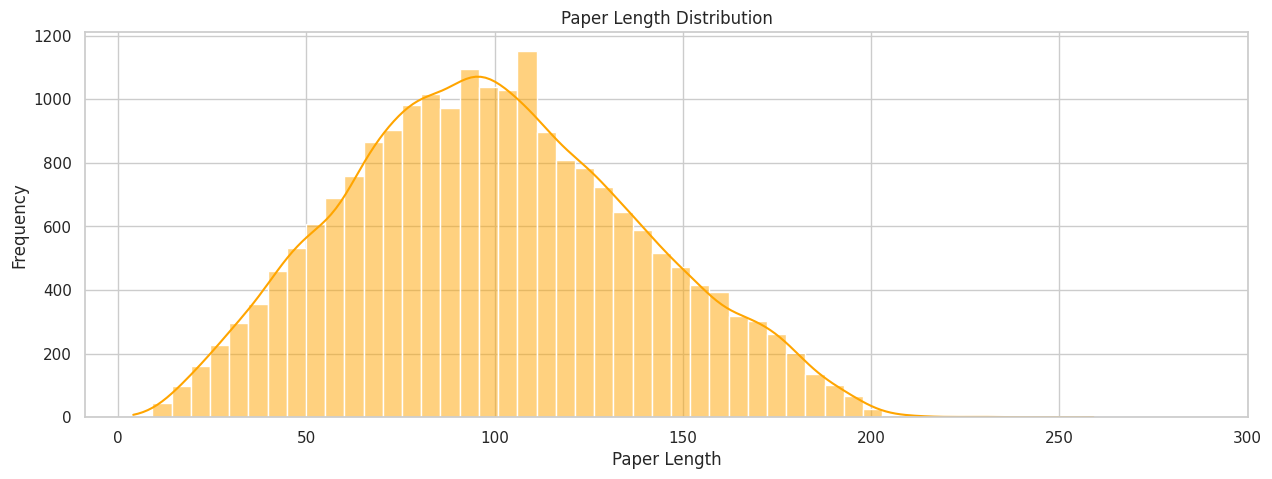

In [35]:
text_lengths = [len(paper.split()) for paper in X_data.flatten()]

sns.set(style="whitegrid")

plt.figure(figsize=(15, 5))
sns.histplot(text_lengths, bins=50, color="orange", kde=True)
plt.title("Paper Length Distribution")
plt.xlabel("Paper Length")
plt.ylabel("Frequency")

plt.xticks(range(0, 300 + 1, 50))

plt.show()

Text vectorization

In [36]:
MAX_FEATURES = 1800
MAX_SEQUENCE = 200 # Maximum length of sequences
tv = TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=MAX_SEQUENCE, output_mode='int')
tv.adapt(X_data)

pickle.dump({'config': tv.get_config(),
             'weights': tv.get_weights()}
            , open("vectorization.pkl", "wb"))

X = np.array(tv(X_data))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.2, random_state=10)

# Evaluate model

In [28]:
NUM_EPOCHS = 5
BATCH_SIZE = 32

def create_model():
    model = Sequential()

    model.add(Embedding(MAX_FEATURES + 1, 64))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(6, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    return model

K-FOLD Cross Validation

In [37]:
FOLDS = 5

KFold_model = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
model = create_model()
iteration = 1
for train_index, val_index in KFold_model.split(X_train):
  print(f"Fold {iteration} iteration")

  # Data split
  X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
  y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

  model.fit(X_fold_train, y_fold_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_fold_val, y_fold_val))

  # Evaluate the model on the validation set of the current fold
  evaluation = model.evaluate(X_fold_val, y_fold_val)

  print(f"Fold {iteration} iteration => Loss: {evaluation[0]:.2f} and Accuracy: {evaluation[1]*100:.2f}%")
  iteration += 1


Fold 1 iteration
Epoch 1/5
420/420 [==============================] - 3s 6ms/step - loss: 0.4707 - accuracy: 0.4406 - val_loss: 0.3969 - val_accuracy: 0.6326
Epoch 2/5
420/420 [==============================] - 3s 7ms/step - loss: 0.3565 - accuracy: 0.6956 - val_loss: 0.3210 - val_accuracy: 0.7417
Epoch 3/5
420/420 [==============================] - 2s 5ms/step - loss: 0.2971 - accuracy: 0.7373 - val_loss: 0.2818 - val_accuracy: 0.7470
Epoch 4/5
420/420 [==============================] - 2s 5ms/step - loss: 0.2667 - accuracy: 0.7562 - val_loss: 0.2605 - val_accuracy: 0.7703
Epoch 5/5
105/105 [==============================] - 0s 2ms/step - loss: 0.2451 - accuracy: 0.7580
Fold 1 iteration => Loss: 0.25 and Accuracy: 75.80%
Fold 2 iteration
Epoch 1/5
420/420 [==============================] - 2s 6ms/step - loss: 0.2335 - accuracy: 0.7703 - val_loss: 0.2262 - val_accuracy: 0.7768
Epoch 2/5
420/420 [==============================] - 2s 6ms/step - loss: 0.2219 - accuracy: 0.7703 - val_loss:

In [38]:
model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

model.summary()

Epoch 1/5
525/525 [==============================] - 2s 5ms/step - loss: 0.1654 - accuracy: 0.7818
Epoch 2/5
525/525 [==============================] - 3s 6ms/step - loss: 0.1638 - accuracy: 0.7826
Epoch 3/5
525/525 [==============================] - 3s 6ms/step - loss: 0.1621 - accuracy: 0.7848
Epoch 4/5
525/525 [==============================] - 2s 5ms/step - loss: 0.1607 - accuracy: 0.7857
Epoch 5/5
525/525 [==============================] - 2s 5ms/step - loss: 0.1593 - accuracy: 0.7861
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          115264    
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)         

Metrics

In [44]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)

precision.update_state(y_test, predictions)
precision_result = precision.result().numpy()
recall.update_state(y_test, predictions)
recall_result = recall.result().numpy()
accuracy.update_state(y_test, predictions)
accuracy_result = accuracy.result().numpy()
f1_result = (2 * precision_result * recall_result) / (precision_result + recall_result)

print("\nMetrics:\n")
print(f"Accuracy:{accuracy_result*100:.2f}%")
print(f"Precision: {precision_result*100:.2f}%")
print(f"Recall:{recall_result*100:.2f}%")
print(f"F-1 Score: {f1_result*100:.2f}%")

132/132 [==============================] - 1s 5ms/step

Metrics:

Accuracy:78.47%
Precision: 83.09%
Recall:75.88%
F-1 Score: 79.32%


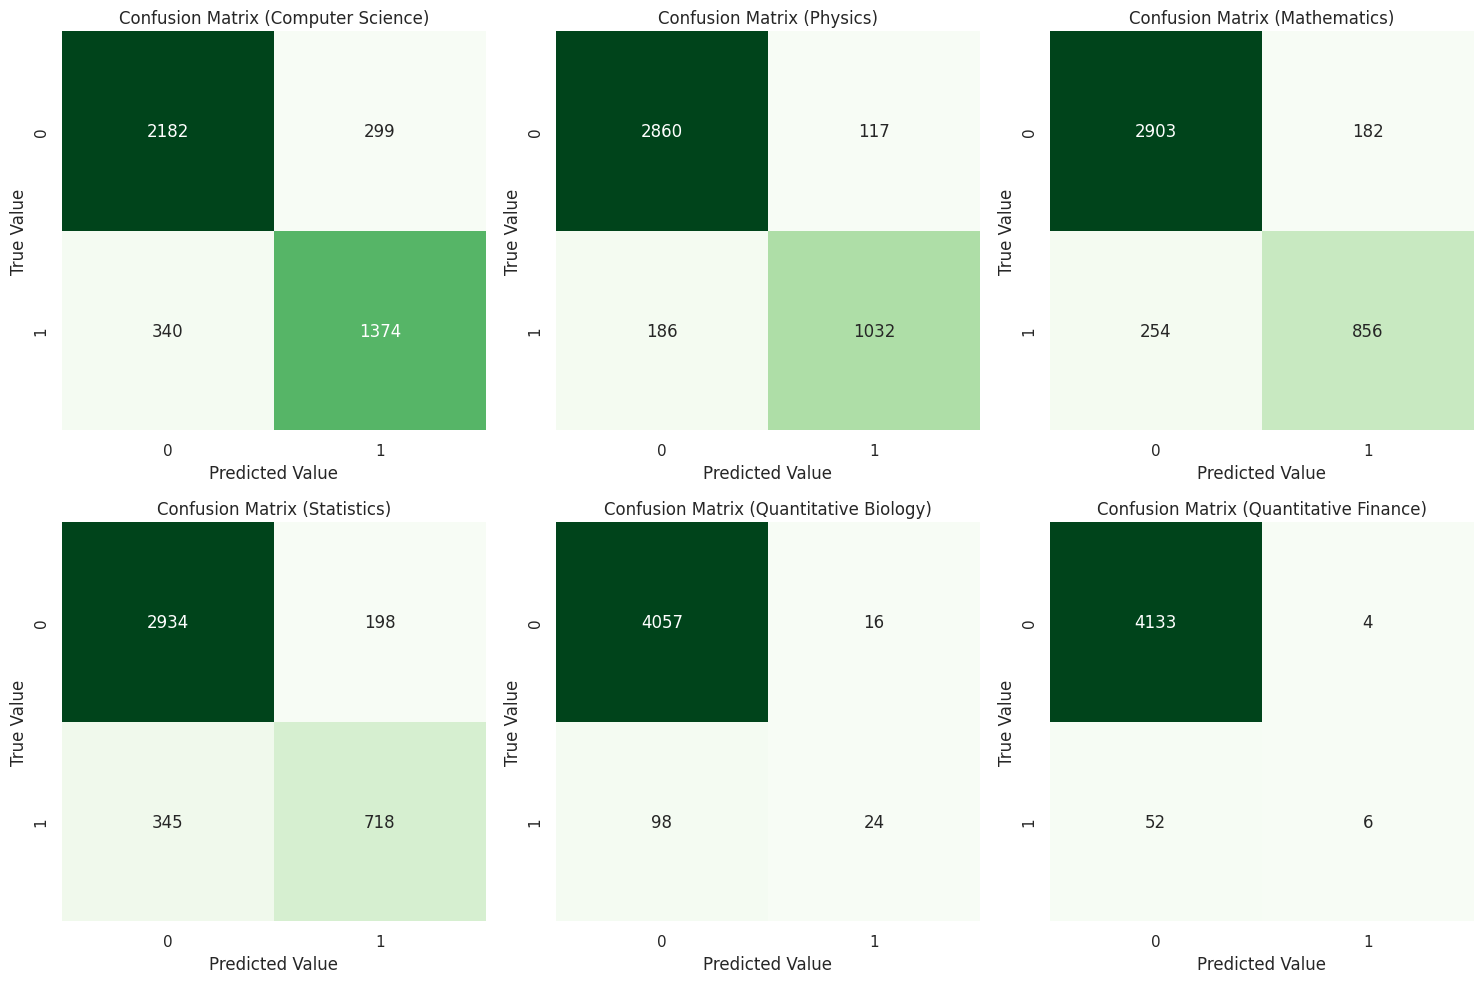

In [47]:
labels = ["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]

num_classes = len(labels)

num_rows = 2
num_cols = min(num_classes, 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

axes = axes.flatten()

for i, label in enumerate(range(num_classes)):
    truth_value = [row[label] for row in y_test]
    prediction = [row[label] for row in predictions]

    matrix = confusion_matrix(truth_value, prediction)

    if num_rows > 1:
        ax = axes[i]
    else:
        ax = axes

    sns.heatmap(matrix, annot=True, fmt="d", cmap="Greens", cbar=False, ax=ax)
    ax.set_xlabel("Predicted Value")
    ax.set_ylabel("True Value")
    ax.set_title(f"Confusion Matrix ({labels[label]})")

plt.tight_layout()
plt.show()

In [48]:
model.save('paper_classification.keras')

# For those classification problems that have a severe class imbalance, the default threshold can result in poor performance. So we decided to calculate thresholds for each category in order to improve the performances

In [49]:
y_pred = model.predict(X_test)
print(len(y_pred))
y_dict={"0":y_pred[:,0].flatten(),"1":y_pred[:,1].flatten(),'2':y_pred[:,2].flatten(),'3':y_pred[:,3].flatten(),'4':y_pred[:, 4].flatten(),'5':y_pred[:, 5].flatten()}
y_df=pd.DataFrame.from_dict(y_dict)

132/132 [==============================] - 0s 2ms/step
4195


In [50]:
from sklearn.metrics import precision_recall_curve

def find_threshold(y_test,y_prob):

    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

    plt.plot(recall, precision, marker='.', label='Model')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

    #Find best threshold
    min_diff=1
    for i in range(len(recall)):
        diff=abs(recall[i] -precision[i])
        if diff<min_diff:
            min_diff=diff
            best_threshold=thresholds[i]
            index=i

    print(f'Precision and Recall for threshold {best_threshold} = {precision[index]} and {recall[index]}')

    return best_threshold

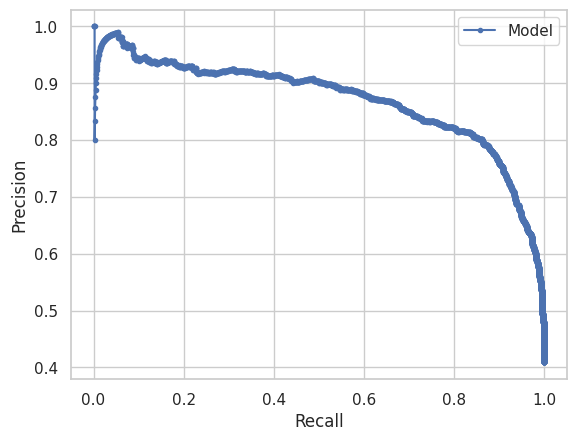

Precision and Recall for threshold 0.4767851233482361 = 0.8162193698949824 and 0.8162193698949824


In [51]:
threshold_cs=find_threshold(y_test[:,0],y_df.iloc[:,0])

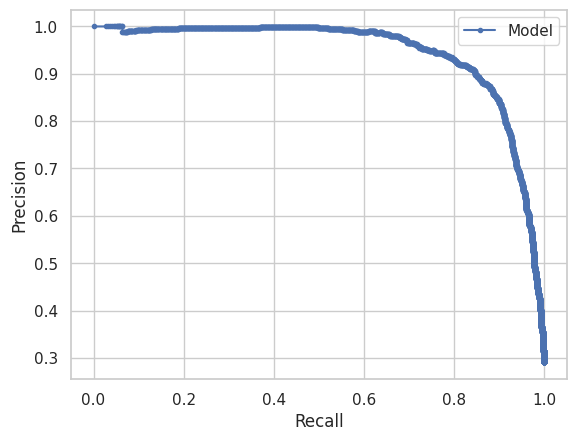

Precision and Recall for threshold 0.37994885444641113 = 0.8752052545155994 and 0.8752052545155994


In [52]:
threshold_ph=find_threshold(y_test[:,1],y_df.iloc[:,1])

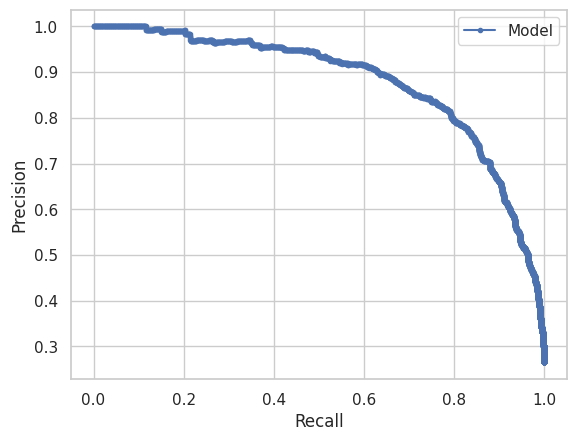

Precision and Recall for threshold 0.44531282782554626 = 0.7981981981981981 and 0.7981981981981981


In [53]:
threshold_math=find_threshold(y_test[:,2],y_df.iloc[:,2])

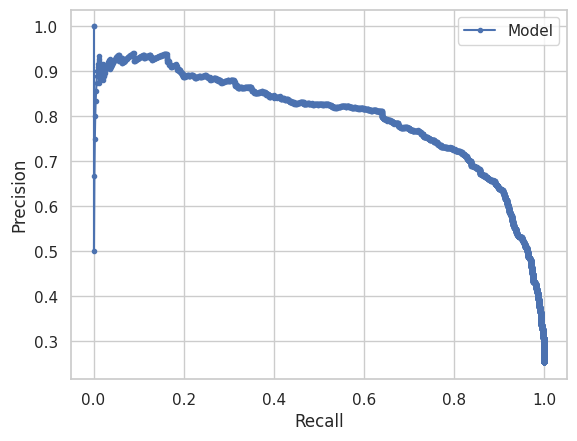

Precision and Recall for threshold 0.403854638338089 = 0.7469426152398871 and 0.7469426152398871


In [54]:
threshold_stat=find_threshold(y_test[:,3],y_df.iloc[:,3])

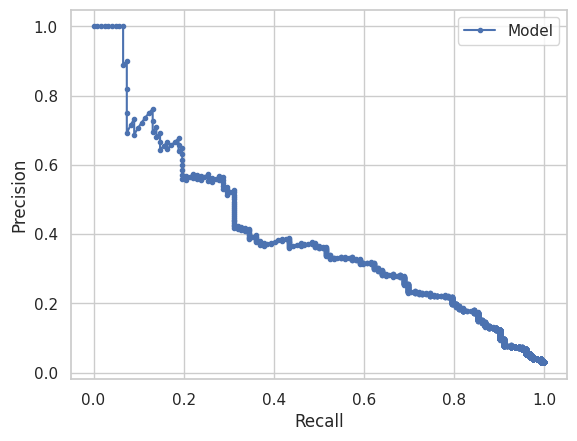

Precision and Recall for threshold 0.17607349157333374 = 0.36885245901639346 and 0.36885245901639346


In [55]:
threshold_qb=find_threshold(y_test[:,4],y_df.iloc[:,4])

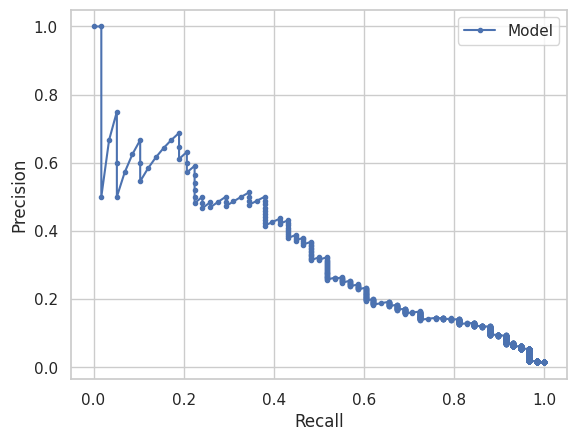

Precision and Recall for threshold 0.120307557284832 = 0.43103448275862066 and 0.43103448275862066


In [56]:
threshold_qf=find_threshold(y_test[:,5],y_df.iloc[:,5])

In [59]:
checkpoint = tf.keras.models.load_model("paper_classification.keras")

# Load 'vectorization.pkl'
from_disk = pickle.load(open("vectorization.pkl", "rb"))

vect = TextVectorization.from_config(from_disk['config'])

vect.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))

vect.set_weights(from_disk['weights'])

thr = {0:threshold_cs,1:threshold_ph,2:threshold_math,3:threshold_stat,4:threshold_qb,5:threshold_qf}

def format_prediction(title: str, abstract: str):
  text = title + abstract
  v = vect([text])

  pred = checkpoint.predict(v, verbose=0)

  result = "Paper has been classified as: "
  categories = []

  for index, label in enumerate(labels):
    if pred[0][index] > thr[index]:
      categories.append(label)
  if len(categories)==0:
    return "Not in the model categories"

  return result + ", ".join(categories)

# We implemented a web scraping function that given a link from the [IEEE Explore](https://ieeexplore.ieee.org) site can predict the class of the paper



In [60]:
import requests
from bs4 import BeautifulSoup

def extract_title_and_abstract(ieee_link):
    # Make a request to the IEEE link
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    response = requests.get(ieee_link, headers=headers)

    if response.status_code == 200:
        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')
        # Extract title
        title_element = soup.find("meta", property="og:title")["content"]
        title = title_element.strip() if title_element else None

        # Extract abstract
        abstract_element = soup.find("meta", property="og:description")["content"]
        abstract = abstract_element.strip() if abstract_element else None

        return title, abstract
    else:
        print(f"Failed to retrieve content. Status code: {response.status_code}")
        return None, None

while True:
  ieee_link = input("Insert the link of the paper from IEEE (type quit to block the execution): ")
  if ieee_link == "quit":
    break
  title, abstract = extract_title_and_abstract(ieee_link)
  if title and abstract:
      print("Title:", title)
      print("Abstract:", abstract)
      print("-"*50)
      print(format_prediction(title, abstract))
      print()
  else:
      print("Error extracting title and abstract.")


Insert the link of the paper from IEEE (type quit to block the execution): https://ieeexplore.ieee.org/document/9804499
Title: PILOT: Synergy between Text Processing and Neural Networks to Detect Self-Admitted Technical Debt
Abstract: During the development phase, software programmers usually introduce code that contains issues intentionally left for additional treatment. To allow for future fixing, they mark such code using textual comments, resulting in Self-Admitted Technical Debt (SATD). Detecting SATD contained in source code has become crucial in the development cycle since it helps program-mers locate issues that need to be solved, thus improving code quality. We introduce PILOT, a technical debt detector built on top of a combination of different natural language processing (NLP) and machine learning (ML) techniques. First, the semantic among SATD comments is captured using feature extraction steps. Then, neural network algorithms are applied to classify comments, represented a